<a href="https://colab.research.google.com/github/abhay25v/Zero-Lag/blob/main/UIDAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/tmp/ipython-input-349637843.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_lagging, x='Ratio', y='state', palette='Reds_r')


Success: 'Winning_Analysis_4_Charts.png' created with 4 graphs.
Top Problem States:
                state     Ratio
0          Meghalaya  2.516880
1           Nagaland  2.205895
2            Manipur  1.566732
3              Bihar  1.273617
4  Arunachal Pradesh  1.142565


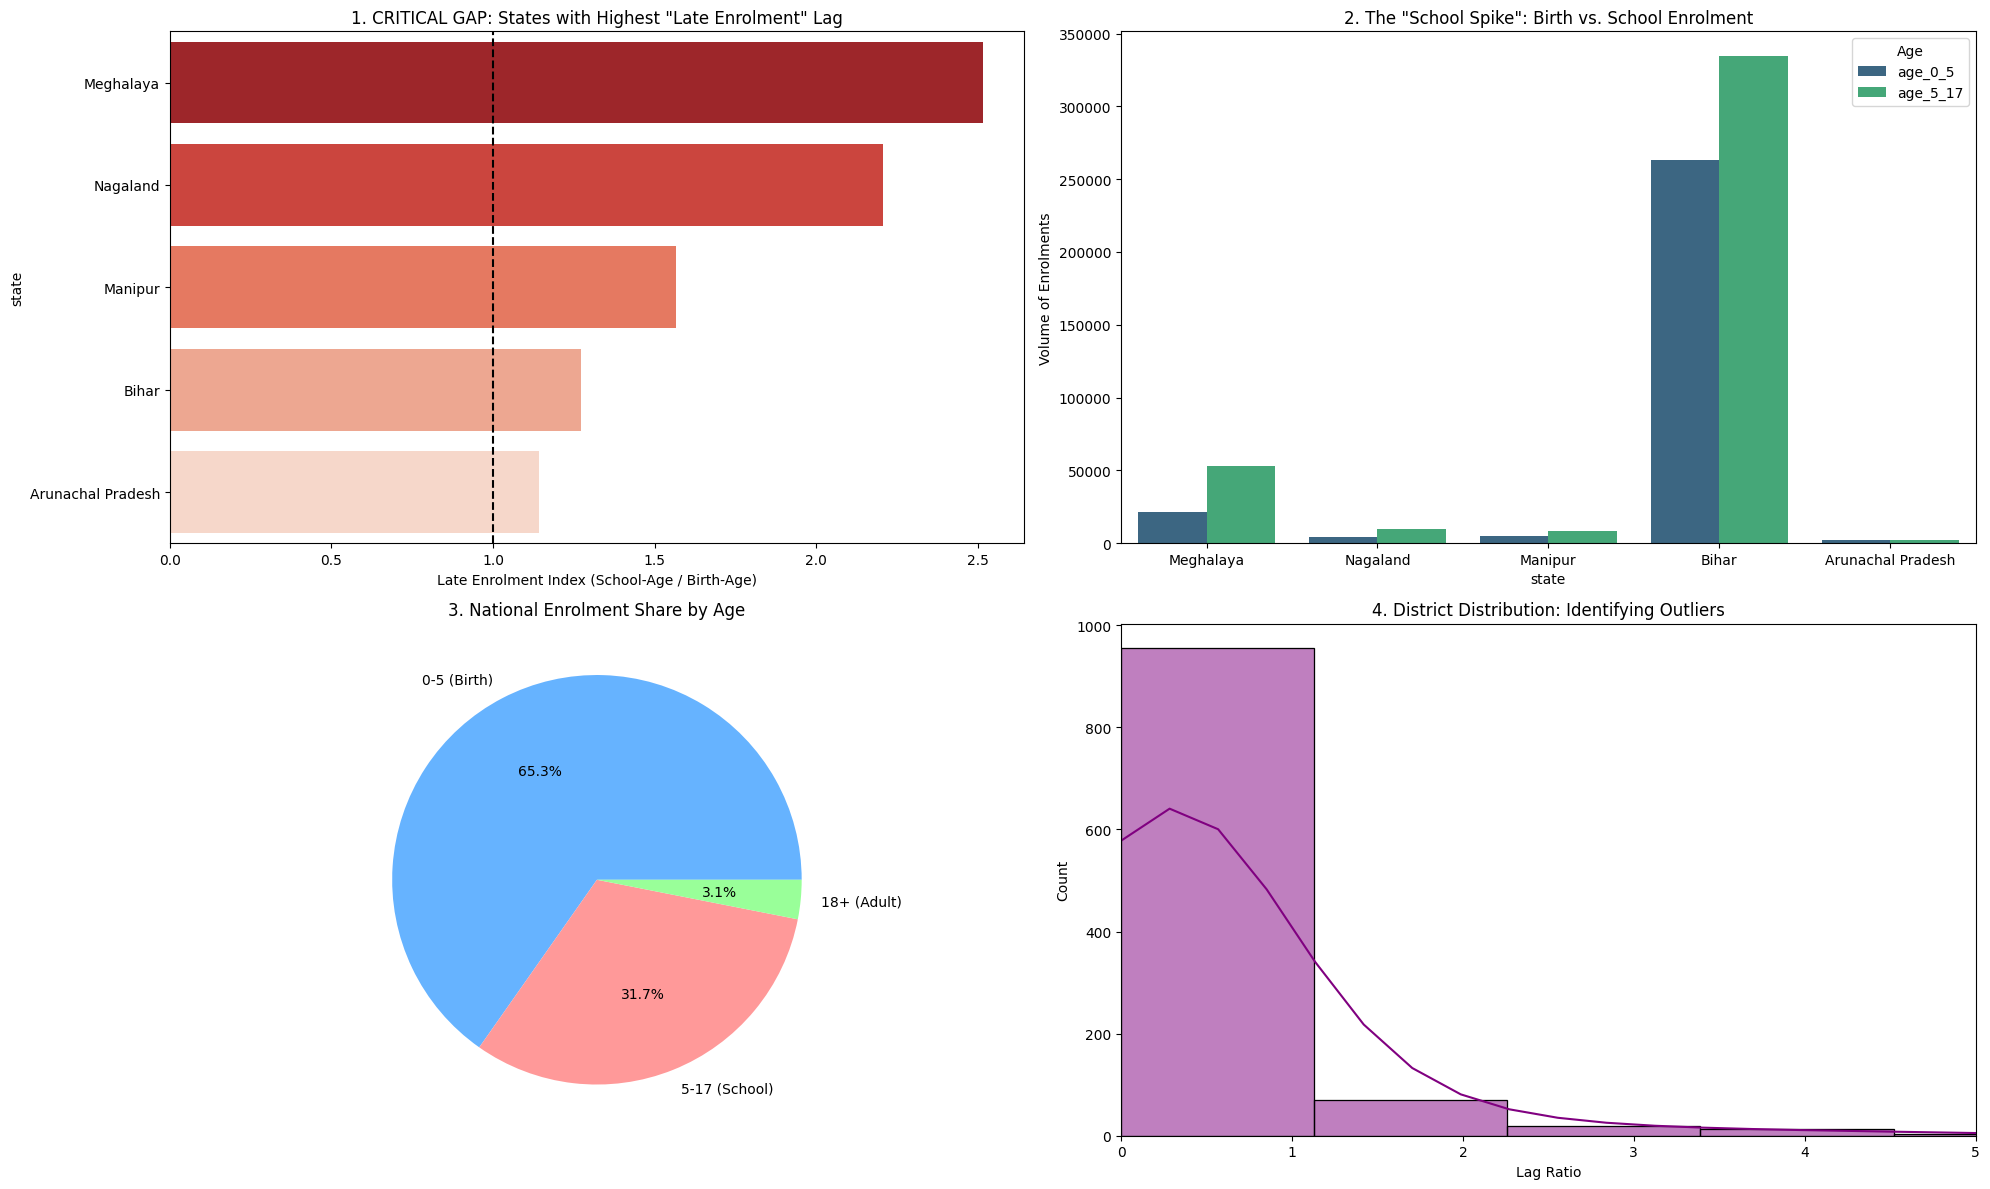

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob

# 1. Load Data (Handles all 3 files automatically)
files = glob.glob('api_data_aadhar_enrolment_*.csv')
df_list = []
for f in files:
    try:
        df_list.append(pd.read_csv(f))
    except:
        pass

if df_list:
    df = pd.concat(df_list, ignore_index=True)

    # 2. Data Cleaning & Feature Engineering
    df['state'] = df['state'].astype(str).str.title().str.strip()
    # Remove junk state names like '100000'
    df = df[~df['state'].str.isnumeric()]

    # The "Lag Index": Ratio of School-Age (5-17) to Birth (0-5) Enrolments
    df['Late_Enrolment_Index'] = df['age_5_17'] / (df['age_0_5'] + 1)

    # 3. Aggregation
    state_stats = df.groupby('state')[['age_0_5', 'age_5_17', 'age_18_greater']].sum()
    state_stats['Ratio'] = state_stats['age_5_17'] / state_stats['age_0_5']
    top_lagging = state_stats.sort_values('Ratio', ascending=False).head(5).reset_index()

    # 4. Generate the 4-Panel Visualization
    plt.figure(figsize=(20, 12))

    # Panel 1: Top Lagging States (The Problem)
    plt.subplot(2, 2, 1)
    sns.barplot(data=top_lagging, x='Ratio', y='state', palette='Reds_r')
    plt.axvline(1.0, color='black', linestyle='--', label='Ideal (1:1)')
    plt.title('1. CRITICAL GAP: States with Highest "Late Enrolment" Lag')
    plt.xlabel('Late Enrolment Index (School-Age / Birth-Age)')

    # Panel 2: Age Composition (The Proof)
    plt.subplot(2, 2, 2)
    lagging_melt = top_lagging.melt(id_vars='state', value_vars=['age_0_5', 'age_5_17'], var_name='Age', value_name='Count')
    sns.barplot(data=lagging_melt, x='state', y='Count', hue='Age', palette='viridis')
    plt.title('2. The "School Spike": Birth vs. School Enrolment')
    plt.ylabel('Volume of Enrolments')

    # Panel 3: National Age Split (The Context)
    plt.subplot(2, 2, 3)
    total_age = df[['age_0_5', 'age_5_17', 'age_18_greater']].sum()
    plt.pie(total_age, labels=['0-5 (Birth)', '5-17 (School)', '18+ (Adult)'], autopct='%1.1f%%', colors=['#66b3ff','#ff9999','#99ff99'])
    plt.title('3. National Enrolment Share by Age')

    # Panel 4: District Anomalies (The Opportunity)
    plt.subplot(2, 2, 4)
    district_lag = df.groupby(['state', 'district'])[['age_0_5', 'age_5_17']].sum().reset_index()
    district_lag['Ratio'] = district_lag['age_5_17'] / (district_lag['age_0_5'] + 1)
    sns.histplot(district_lag['Ratio'], bins=50, kde=True, color='purple')
    plt.xlim(0, 5)
    plt.title('4. District Distribution: Identifying Outliers')
    plt.xlabel('Lag Ratio')

    plt.tight_layout()
    plt.savefig('Winning_Analysis_4_Charts.png')
    print("Success: 'Winning_Analysis_4_Charts.png' created with 4 graphs.")
    print("Top Problem States:\n", top_lagging[['state', 'Ratio']])
else:
    print("No CSV files found. Please upload the files.")